# Normal

In [ ]:
import gym
from gym import spaces
import numpy as np

class EVBrakingEnv(gym.Env):
    def __init__(self):
        super(EVBrakingEnv, self).__init__()

        # Action space represents braking force in the range [-1, 1] (for reverse to maximum braking).
        self.action_space = spaces.Box(low=np.array([-1]), high=np.array([1]), dtype=np.float32)

        # Observation space: [speed, incline, battery level, braking force]
        # Speed (0 to 30 m/s), Incline (-1 to 1 normalized), Battery Level (0 to 1), Braking Force (-1 to 1).
        self.observation_space = spaces.Box(low=np.array([0, -1, 0, -1]),
                                            high=np.array([30, 1, 1, 1]),
                                            dtype=np.float32)

        # Initial vehicle parameters
        self.speed = np.random.uniform(10, 20)  # Initial speed between 10 and 20 m/s
        self.incline = np.random.uniform(-0.1, 0.1)  # Incline factor
        self.battery_level = 1.0  # Full battery
        self.time_step = 0.1  # Simulation time step

    def reset(self):
        # Reset the state for a new episode
        self.speed = np.random.uniform(10, 20)
        self.incline = np.random.uniform(-0.1, 0.1)
        self.battery_level = np.random.uniform(0.3, 1.0)

        return np.array([self.speed, self.incline, self.battery_level, 0])

    def step(self, action):
        brake_force = action[0]  # Extract braking force from the action

        # Adjust speed based on braking force and incline
        speed_loss = brake_force * 2 + self.incline  # Brake effect + incline impact
        self.speed = max(0, self.speed - speed_loss * self.time_step)  # Speed can't be negative

        # Update battery level based on braking force (simulating energy recovery)
        battery_recovery = max(0, brake_force) * 0.01
        self.battery_level = min(1.0, self.battery_level + battery_recovery)  # Max battery level = 1

        # Define the reward (positive for energy recovery, small penalty for strong braking)
        reward = battery_recovery - abs(brake_force) * 0.01
        done = self.speed <= 0.5  # Episode ends when car nearly stops

        # Construct observation
        observation = np.array([self.speed, self.incline, self.battery_level, brake_force])
        return observation, reward, done, {}

    def render(self, mode="human"):
        # Display key information about the current state for debugging
        print(f"Speed: {self.speed:.2f}, Incline: {self.incline:.2f}, Battery Level: {self.battery_level:.2f}, Braking Force: {self.brake_force:.2f}")

    def close(self):
        pass


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.max_action * torch.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x, u):
        x = torch.cat([x, u], 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# class DDPGAgent:
#     def __init__(self, state_dim, action_dim, max_action):
#         self.actor = Actor(state_dim, action_dim, max_action).to(device)
#         self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
#         self.actor_target.load_state_dict(self.actor.state_dict())
#         self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

#         self.critic = Critic(state_dim, action_dim).to(device)
#         self.critic_target = Critic(state_dim, action_dim).to(device)
#         self.critic_target.load_state_dict(self.critic.state_dict())
#         self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

#         self.replay_buffer = deque(maxlen=100000)
#         self.max_action = max_action

#     def select_action(self, state):
#         state = torch.FloatTensor(state.reshape(1, -1)).to(device)
#         return self.actor(state).cpu().data.numpy().flatten()

#     def train(self, batch_size=64, gamma=0.99, tau=0.005):
#         # Sample replay buffer
#         state, action, reward, next_state, done = zip(*random.sample(self.replay_buffer, batch_size))
#         state = torch.FloatTensor(np.array(state)).to(device)
#         action = torch.FloatTensor(np.array(action)).to(device)
#         reward = torch.FloatTensor(np.array(reward)).to(device).unsqueeze(1)
#         next_state = torch.FloatTensor(np.array(next_state)).to(device)
#         done = torch.FloatTensor(np.array(done)).to(device).unsqueeze(1)

#         # Compute target
#         target_action = self.actor_target(next_state)
#         target_q = self.critic_target(next_state, target_action)
#         target_q = reward + (1 - done) * gamma * target_q

#         # Critic loss
#         current_q = self.critic(state, action)
#         critic_loss = nn.MSELoss()(current_q, target_q)

#         # Actor loss
#         actor_loss = -self.critic(state, self.actor(state)).mean()

#         # Optimize the critic
#         self.critic_optimizer.zero_grad()
#         critic_loss.backward()
#         self.critic_optimizer.step()

#         # Optimize the actor
#         self.actor_optimizer.zero_grad()
#         actor_loss.backward()
#         self.actor_optimizer.step()

#         # Soft update of target networks
#         for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
#             target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

#         for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
#             target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

#     def add_to_replay_buffer(self, state, action, reward, next_state, done):
#         self.replay_buffer.append((state, action, reward, next_state, done))

class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = deque(maxlen=100000)
        self.max_action = max_action

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, batch_size=64, gamma=0.99, tau=0.005):
        # Sample replay buffer
        batch = random.sample(self.replay_buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        state = torch.FloatTensor(np.array(state)).to(device)
        action = torch.FloatTensor(np.array(action)).to(device)
        reward = torch.FloatTensor(np.array(reward)).to(device).unsqueeze(1)
        next_state = torch.FloatTensor(np.array(next_state)).to(device)
        done = torch.FloatTensor(np.array(done)).to(device).unsqueeze(1)

        # Compute target Q value
        with torch.no_grad():
            target_action = self.actor_target(next_state)
            target_q = self.critic_target(next_state, target_action)
            target_q = reward + (1 - done) * gamma * target_q

        # Compute current Q estimate
        current_q = self.critic(state, action)

        # Critic loss
        critic_loss = nn.MSELoss()(current_q, target_q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update the target networks
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def add_to_replay_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = EVBrakingEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = DDPGAgent(state_dim, action_dim, max_action)

# Training loop
num_episodes = 100
batch_size = 64

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.add_to_replay_buffer(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if len(agent.replay_buffer) > batch_size:
            agent.train(batch_size)

        if done:
            break

    print(f"Episode: {episode}, Reward: {episode_reward}")

env.close()


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode: 0, Reward: -0.44172688305377955
Episode: 1, Reward: 0.0
Episode: 2, Reward: 0.0
Episode: 3, Reward: 0.0
Episode: 4, Reward: 0.0
Episode: 5, Reward: 0.0
Episode: 6, Reward: -1.0933616867661478
Episode: 7, Reward: 0.0
Episode: 8, Reward: 0.0
Episode: 9, Reward: 0.0
Episode: 10, Reward: 0.0
Episode: 11, Reward: 0.0
Episode: 12, Reward: 0.0
Episode: 13, Reward: 0.0
Episode: 14, Reward: 0.0
Episode: 15, Reward: 0.0
Episode: 16, Reward: 0.0
Episode: 17, Reward: 0.0
Episode: 18, Reward: 0.0
Episode: 19, Reward: 0.0
Episode: 20, Reward: 0.0
Episode: 21, Reward: 0.0
Episode: 22, Reward: 0.0
Episode: 23, Reward: 0.0
Episode: 24, Reward: 0.0
Episode: 25, Reward: 0.0
Episode: 26, Reward: 0.0
Episode: 27, Reward: 0.0
Episode: 28, Reward: 0.0
Episode: 29, Reward: 0.0
Episode: 30, Reward: 0.0
Episode: 31, Reward: -0.08934919357299806
Episode: 32, Reward: -0.0621311154961586
Episode: 33, Reward: -0.0015378537774085998
Episode: 34, Reward: 0.0
Episode: 35, Reward: -0.0023287367820739747
Episod

# With Graphs

In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt

class RegenerativeBrakingEnv(gym.Env):
    def __init__(self):
        super(RegenerativeBrakingEnv, self).__init__()

        self.speed = np.random.uniform(20, 60)  # initial speed in km/h
        self.battery_soc = 0.5  # initial battery state of charge (50%)
        self.max_soc = 1.0  # battery's max SOC
        self.min_soc = 0.0  # battery's min SOC
        self.max_speed = 100  # maximum speed for the vehicle in km/h

        # Define action and observation space
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)

    def reset(self):
        self.speed = np.random.uniform(20, 60)
        self.battery_soc = 0.5
        return np.array([self.speed, self.battery_soc])

    def step(self, action):
        braking_force = (action[0] + 1) / 2  # Scale action to [0, 1] as braking force

        energy_recovered = braking_force * self.speed / 100.0  # Simplified energy recovery model
        self.battery_soc = min(self.max_soc, self.battery_soc + energy_recovered)

        # Update speed after applying braking force
        self.speed = max(0, self.speed - braking_force * 5)

        # Calculate reward
        reward = energy_recovered - 0.1 * abs(braking_force - 0.5)  # reward energy and smoothness

        # Check if episode is done
        done = self.speed <= 0 or self.battery_soc >= self.max_soc

        # Update observation
        obs = np.array([self.speed, self.battery_soc])

        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Speed: {self.speed:.2f} km/h, Battery SOC: {self.battery_soc * 100:.2f}%")


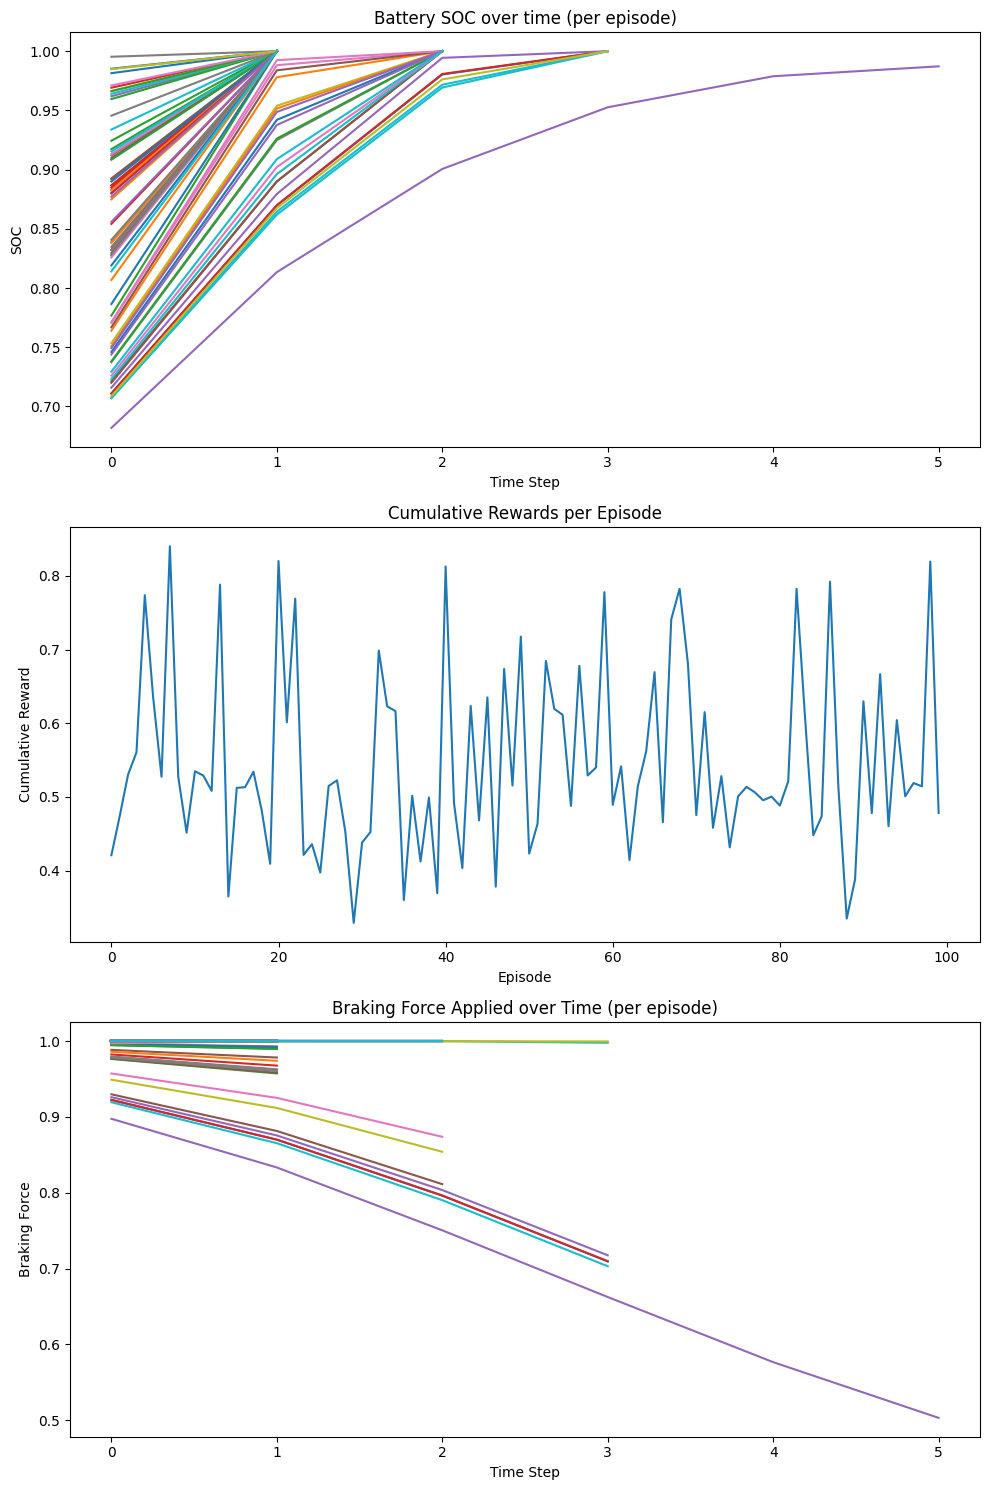

In [9]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = RegenerativeBrakingEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = DDPGAgent(state_dim=2, action_dim=1, max_action=1)

num_episodes = 100
batch_size = 64

soc_history = []
reward_history = []
braking_force_history = []

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    episode_reward = 0
    episode_soc = []
    episode_rewards = []
    episode_braking_force = []

    while not done:
        action = agent.select_action(obs)
        new_obs, reward, done, _ = env.step(action)

        # Track details
        episode_soc.append(env.battery_soc)
        episode_rewards.append(reward)
        episode_braking_force.append((action[0] + 1) / 2)

        # Add experience to replay buffer
        agent.add_to_replay_buffer(obs, action, reward, new_obs, done)
        obs = new_obs
        episode_reward += reward

        # Train agent
        if len(agent.replay_buffer) > batch_size:
            agent.train(batch_size)

    soc_history.append(episode_soc)
    reward_history.append(episode_reward)
    braking_force_history.append(episode_braking_force)

# Plot the results
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Battery SOC over episodes
for soc in soc_history:
    axs[0].plot(soc)
axs[0].set_title("Battery SOC over time (per episode)")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("SOC")

# Cumulative rewards over episodes
axs[1].plot(reward_history)
axs[1].set_title("Cumulative Rewards per Episode")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Cumulative Reward")

# Braking force over episodes
for bf in braking_force_history:
    axs[2].plot(bf)
axs[2].set_title("Braking Force Applied over Time (per episode)")
axs[2].set_xlabel("Time Step")
axs[2].set_ylabel("Braking Force")

plt.tight_layout()
plt.show()


# Comparison

<ipython-input-10-901879563362>:101: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


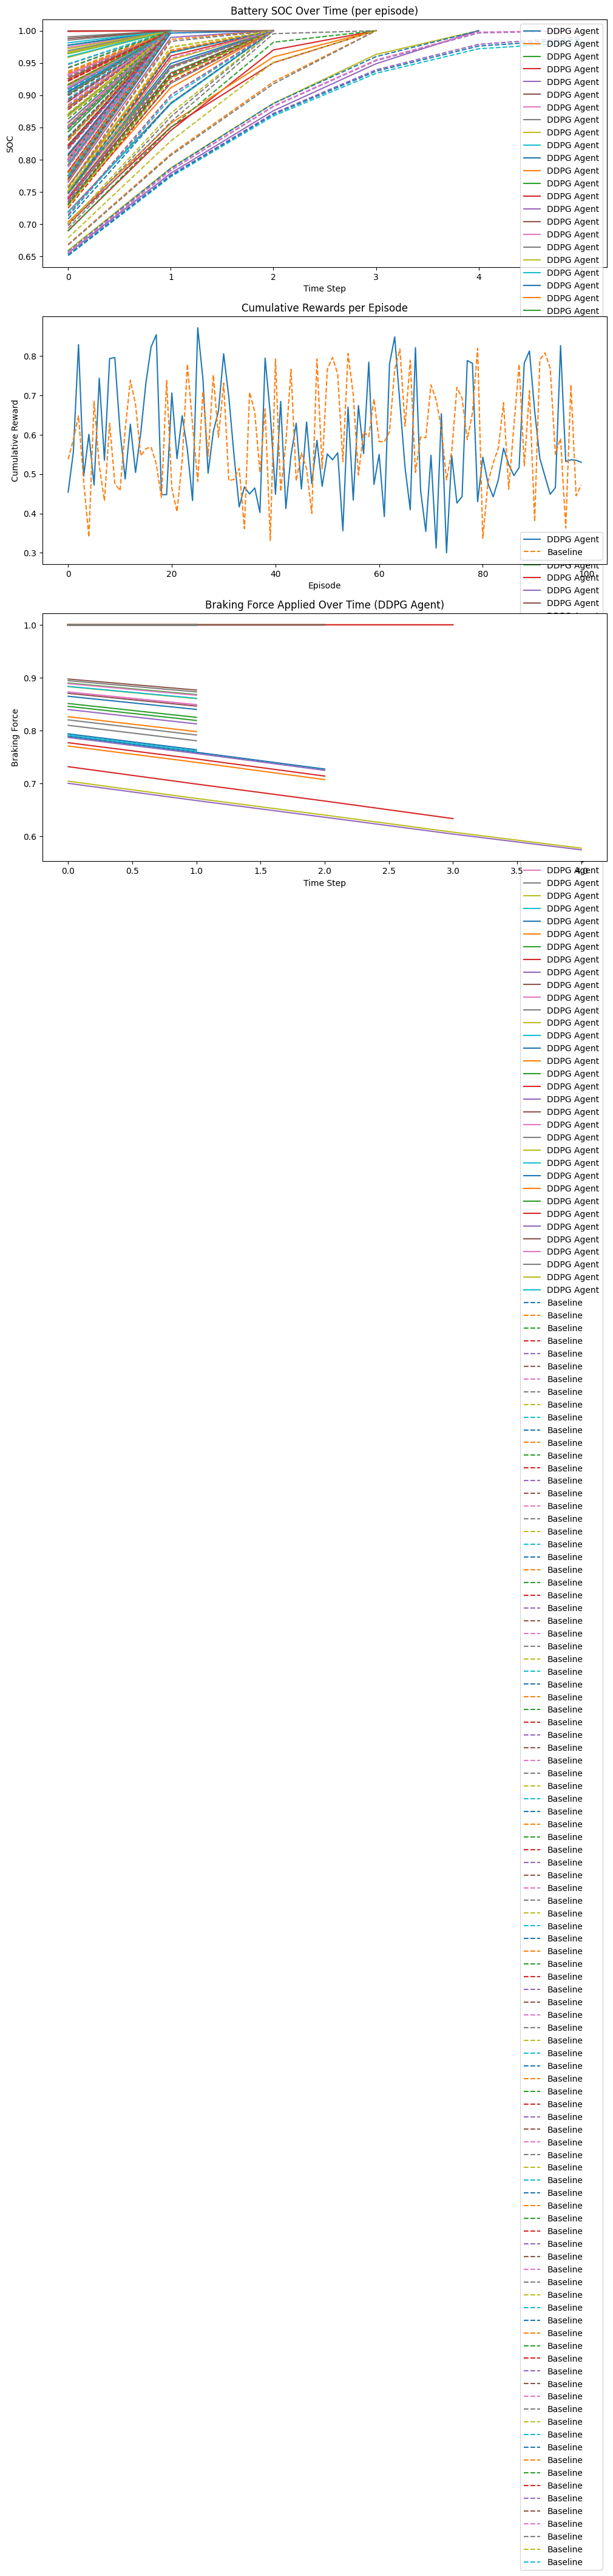

In [10]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming your environment and DDPG agent classes are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = RegenerativeBrakingEnv()
agent = DDPGAgent(state_dim=2, action_dim=1, max_action=1)

num_episodes = 100
batch_size = 64

# Metrics to track
soc_history = []
reward_history = []
braking_force_history = []
baseline_soc_history = []
baseline_reward_history = []

# Baseline policy: constant moderate braking
def baseline_policy(observation):
    return np.array([0.5])  # Moderate constant braking force

for episode in range(num_episodes):
    # DDPG agent run
    obs = env.reset()
    done = False
    episode_reward = 0
    episode_soc = []
    episode_braking_force = []

    while not done:
        # Agent's action and environment step
        action = agent.select_action(obs)
        new_obs, reward, done, _ = env.step(action)

        # Track metrics for DDPG agent
        episode_soc.append(env.battery_soc)
        episode_braking_force.append((action[0] + 1) / 2)

        agent.add_to_replay_buffer(obs, action, reward, new_obs, done)
        obs = new_obs
        episode_reward += reward

        # Train agent
        if len(agent.replay_buffer) > batch_size:
            agent.train(batch_size)

    soc_history.append(episode_soc)
    reward_history.append(episode_reward)
    braking_force_history.append(episode_braking_force)

    # Baseline policy run for comparison
    obs = env.reset()
    done = False
    baseline_episode_reward = 0
    baseline_soc = []

    while not done:
        # Baseline constant braking action
        action = baseline_policy(obs)
        new_obs, reward, done, _ = env.step(action)

        # Track SOC for baseline
        baseline_soc.append(env.battery_soc)
        baseline_episode_reward += reward
        obs = new_obs

    baseline_soc_history.append(baseline_soc)
    baseline_reward_history.append(baseline_episode_reward)

# Plot results
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Battery SOC over episodes
for soc in soc_history:
    axs[0].plot(soc, label='DDPG Agent')
for soc in baseline_soc_history:
    axs[0].plot(soc, linestyle='--', label='Baseline')
axs[0].set_title("Battery SOC Over Time (per episode)")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("SOC")
axs[0].legend()

# Cumulative rewards over episodes
axs[1].plot(reward_history, label="DDPG Agent")
axs[1].plot(baseline_reward_history, label="Baseline", linestyle='--')
axs[1].set_title("Cumulative Rewards per Episode")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Cumulative Reward")
axs[1].legend()

# Braking force applied over time
for bf in braking_force_history:
    axs[2].plot(bf)
axs[2].set_title("Braking Force Applied Over Time (DDPG Agent)")
axs[2].set_xlabel("Time Step")
axs[2].set_ylabel("Braking Force")

plt.tight_layout()
plt.show()


# With Battery Status


Episode 1/100:
  Total Reward: -807.5000503063187
  Battery SOC: 89.50000005960474%
  Total Recovery Time: 2209.995499357581 sec
  Total Consumption: 1515.0000000000016
  Time Remaining: 0 sec
  Overheat Events: 66
  Overcool Events: 15

Episode 2/100:
  Total Reward: -989.9999999999983
  Battery SOC: 70.00000000000028%
  Total Recovery Time: 0.0 sec
  Total Consumption: 1515.0000000000016
  Time Remaining: 0 sec
  Overheat Events: 66
  Overcool Events: 111

Episode 3/100:
  Total Reward: -989.9999999999983
  Battery SOC: 70.00000000000028%
  Total Recovery Time: 0.0 sec
  Total Consumption: 1515.0000000000016
  Time Remaining: 0 sec
  Overheat Events: 66
  Overcool Events: 207

Episode 4/100:
  Total Reward: -989.9999999999983
  Battery SOC: 70.00000000000028%
  Total Recovery Time: 0.0 sec
  Total Consumption: 1515.0000000000016
  Time Remaining: 0 sec
  Overheat Events: 66
  Overcool Events: 303

Episode 5/100:
  Total Reward: -989.9999999999983
  Battery SOC: 70.00000000000028%
  T

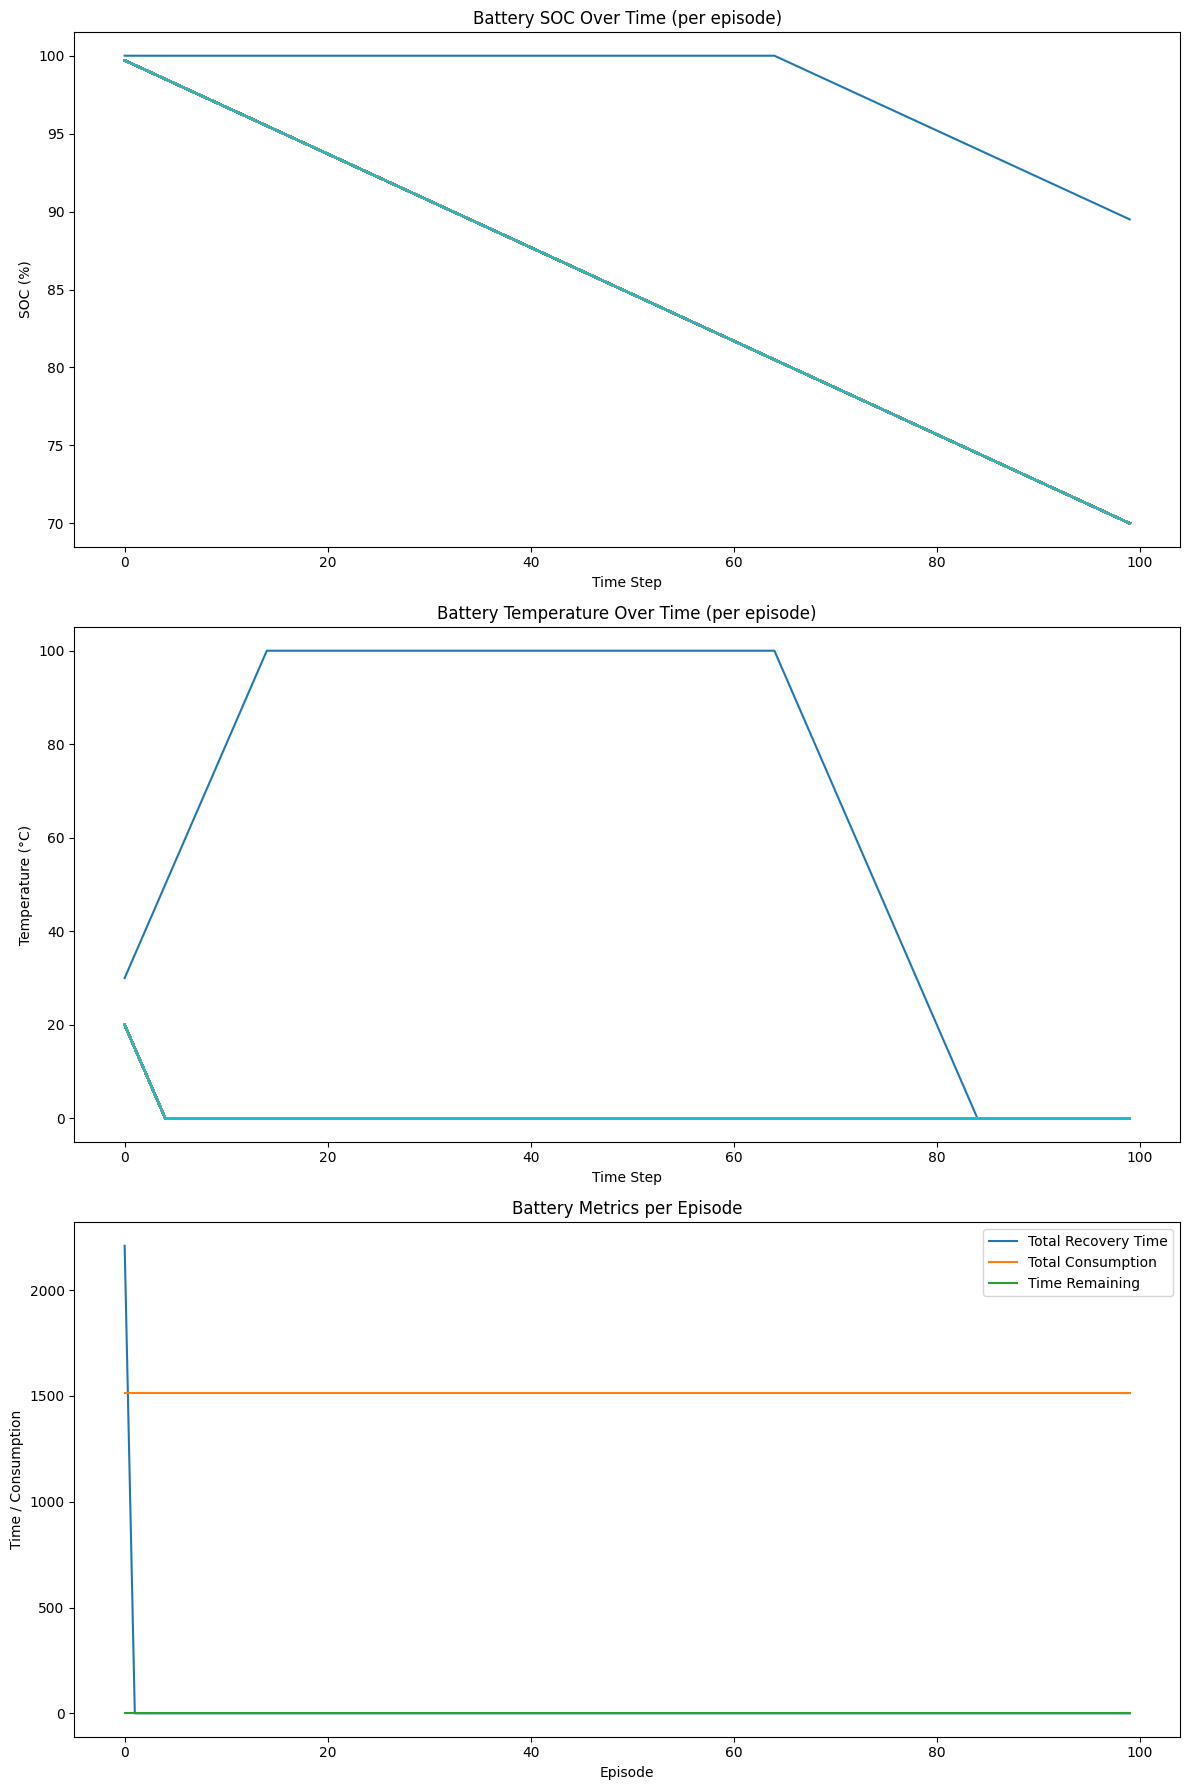

In [11]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming your environment and DDPG agent classes are already defined

class RegenerativeBrakingEnv(gym.Env):
    def __init__(self):
        super(RegenerativeBrakingEnv, self).__init__()
        # Original attributes
        self.battery_soc = 100.0
        self.temperature = 25.0  # in Celsius
        self.recovery_time = 0
        self.battery_consumption = 0
        self.time_remaining = 0

        # Constants for temperature checks
        self.overheat_temp = 60
        self.overcool_temp = 0
        self.time_step_duration = 1  # Each time step in seconds

        # State and action spaces
        self.state = np.array([self.battery_soc, self.temperature])
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(2,))

    def reset(self):
        self.battery_soc = 100.0
        self.temperature = 25.0
        self.recovery_time = 0
        self.battery_consumption = 0
        self.time_remaining = 100  # estimated operational time
        self.state = np.array([self.battery_soc, self.temperature])
        return self.state

    def step(self, action):
        braking_force = (action[0] + 1) / 2  # Normalize action to [0, 1]

        # Update battery SOC and recovery stats
        soc_recovery = braking_force * 0.5
        soc_consumption = 0.3  # Example fixed consumption per time step

        self.battery_soc = max(0, min(self.battery_soc + soc_recovery - soc_consumption, 100))
        self.recovery_time += soc_recovery
        self.battery_consumption += soc_consumption
        self.time_remaining = max(0, self.time_remaining - self.time_step_duration)

        # Temperature dynamics
        temp_change = (braking_force - 0.5) * 10  # Simplified change
        self.temperature = max(0, min(self.temperature + temp_change, 100))

        # Check if temperature exceeds safe limits
        overheat = self.temperature >= self.overheat_temp
        overcool = self.temperature <= self.overcool_temp

        # Reward calculation
        reward = soc_recovery - soc_consumption - (10 if overheat or overcool else 0)

        # Update state
        self.state = np.array([self.battery_soc, self.temperature])
        done = self.battery_soc <= 0 or self.time_remaining <= 0

        return self.state, reward, done, {"overheat": overheat, "overcool": overcool}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = RegenerativeBrakingEnv()
agent = DDPGAgent(state_dim=2, action_dim=1, max_action=1)

# Track metrics per episode
num_episodes = 100
batch_size = 64

battery_soc_history = []
temperature_history = []
recovery_time_history = []
consumption_history = []
time_remaining_history = []
overheat_count = 0
overcool_count = 0

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    episode_reward = 0
    episode_soc = []
    episode_temperature = []
    episode_recovery_time = 0
    episode_consumption = 0
    episode_time_remaining = env.time_remaining

    while not done:
        action = agent.select_action(obs)
        new_obs, reward, done, info = env.step(action)

        # Track metrics
        episode_soc.append(env.battery_soc)
        episode_temperature.append(env.temperature)
        episode_recovery_time += env.recovery_time
        episode_consumption += env.battery_consumption
        episode_time_remaining = env.time_remaining

        # Check overheat/overcool events
        if info["overheat"]:
            overheat_count += 1
        if info["overcool"]:
            overcool_count += 1

        # Train the agent
        agent.add_to_replay_buffer(obs, action, reward, new_obs, done)
        if len(agent.replay_buffer) > batch_size:
            agent.train(batch_size)

        episode_reward += reward
        obs = new_obs

    # Append per-episode data
    battery_soc_history.append(episode_soc)
    temperature_history.append(episode_temperature)
    recovery_time_history.append(episode_recovery_time)
    consumption_history.append(episode_consumption)
    time_remaining_history.append(episode_time_remaining)

    print(f"Episode {episode+1}/{num_episodes}:")
    print(f"  Total Reward: {episode_reward}")
    print(f"  Battery SOC: {episode_soc[-1]}%")
    print(f"  Total Recovery Time: {episode_recovery_time} sec")
    print(f"  Total Consumption: {episode_consumption}")
    print(f"  Time Remaining: {episode_time_remaining} sec")
    print(f"  Overheat Events: {overheat_count}")
    print(f"  Overcool Events: {overcool_count}")
    print("")

# Plotting metrics
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Battery SOC over episodes
for soc in battery_soc_history:
    axs[0].plot(soc, label='Battery SOC')
axs[0].set_title("Battery SOC Over Time (per episode)")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("SOC (%)")

# Temperature over episodes
for temp in temperature_history:
    axs[1].plot(temp, label='Temperature')
axs[1].set_title("Battery Temperature Over Time (per episode)")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Temperature (°C)")

# Recovery time, consumption, and time remaining per episode
axs[2].plot(recovery_time_history, label="Total Recovery Time")
axs[2].plot(consumption_history, label="Total Consumption")
axs[2].plot(time_remaining_history, label="Time Remaining")
axs[2].set_title("Battery Metrics per Episode")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Time / Consumption")
axs[2].legend()

plt.tight_layout()
plt.show()
